## Customer Purchase Behavior

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

### Load orders, customers, order items

In [8]:
orders = pd.read_csv('data/olist_orders_dataset.csv')
customers = pd.read_csv('data/olist_customers_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')

# Convert timestamp to datetime format
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Aggregate total price per order
order_price = order_items.groupby('order_id')['price'].sum().reset_index()

# Merge orders with customers to get state info
orders_customers = orders.merge(customers, on='customer_id', how='left')

# Merge with total price per order
df = orders_customers.merge(order_price, on='order_id', how='left')

# Keep only delivered orders
df = df[df['order_status'] == 'delivered']

# Convert other relevant date columns to datetime 
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'], errors='coerce')
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'], errors='coerce')
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96478 entries, 0 to 99440
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96478 non-null  object        
 1   customer_id                    96478 non-null  object        
 2   order_status                   96478 non-null  object        
 3   order_purchase_timestamp       96478 non-null  datetime64[ns]
 4   order_approved_at              96464 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96476 non-null  object        
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96478 non-null  datetime64[ns]
 8   customer_unique_id             96478 non-null  object        
 9   customer_zip_code_prefix       96478 non-null  int64         
 10  customer_city                  96478 non-null  object        
 11  customer_state      

### Number of orders by state

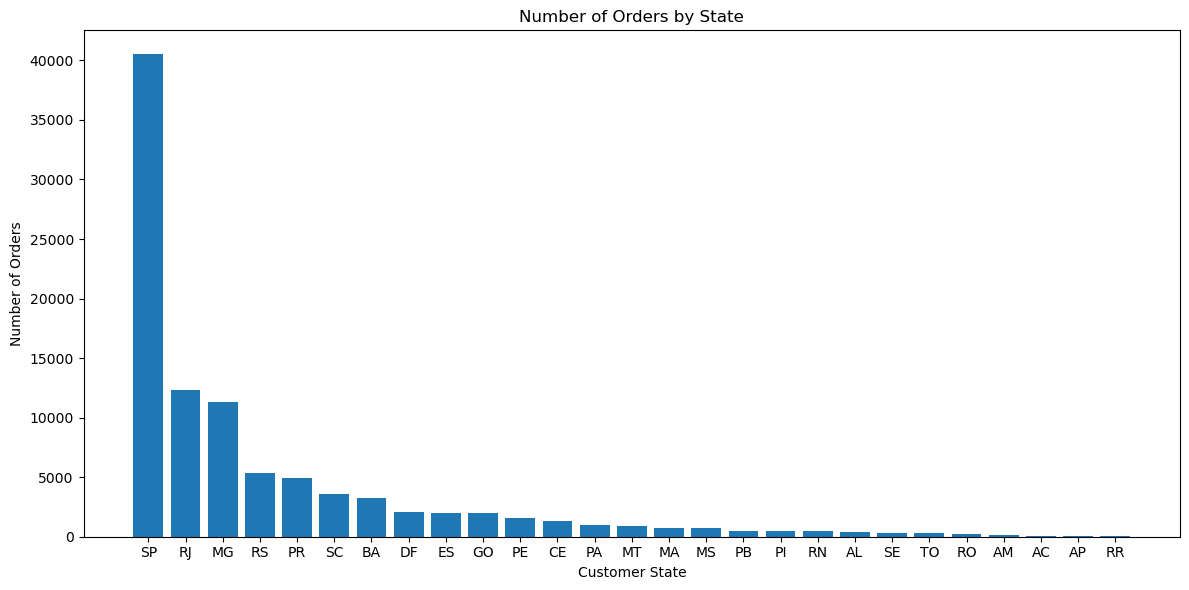

In [10]:
state_orders = df.groupby('customer_state').agg(
    order_count=('order_id', 'count'),
    avg_order_value=('price', 'mean')
).reset_index()

# Sort by number of orders
state_orders = state_orders.sort_values(by='order_count', ascending=False)

# plot a bar chart by state
plt.figure(figsize=(12,6))
plt.bar(state_orders['customer_state'], state_orders['order_count'])
plt.title('Number of Orders by State')
plt.xlabel('Customer State')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()


### Daily order trend

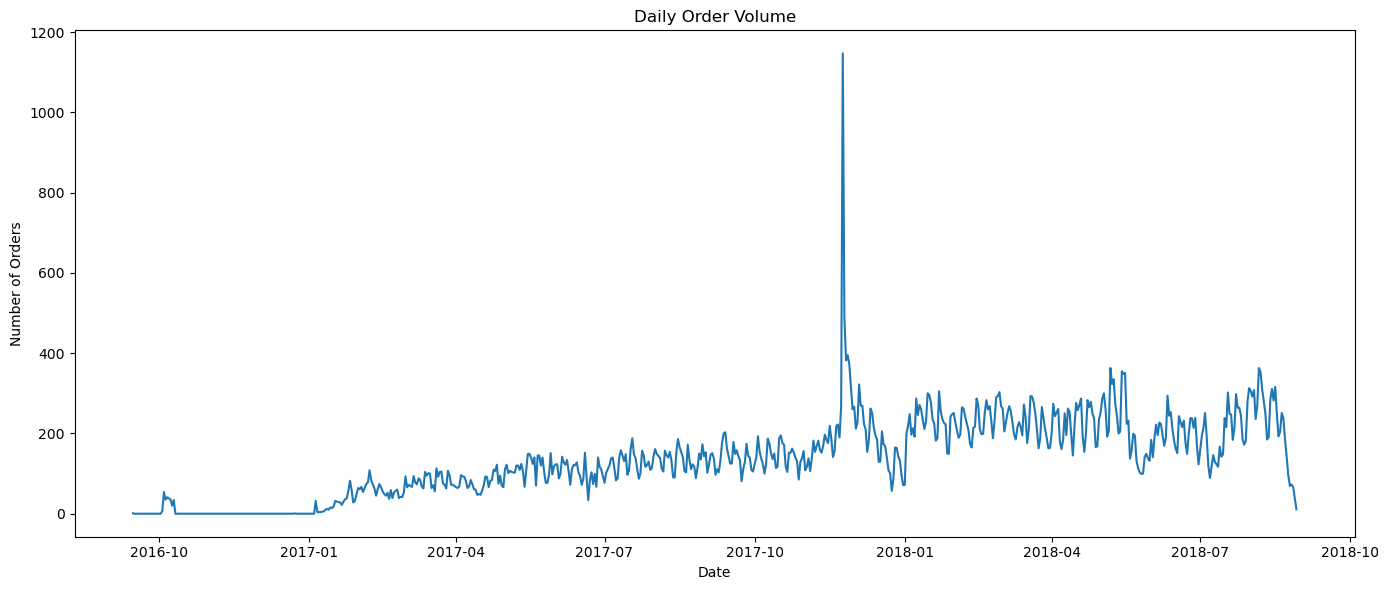

In [12]:
# Set datetime index
df.set_index('order_purchase_timestamp', inplace=True)

# Resample to daily frequency and count number of orders
daily_orders = df.resample('D')['order_id'].count()

# Plot daily order volume
plt.figure(figsize=(14,6))
plt.plot(daily_orders.index, daily_orders.values)
plt.title('Daily Order Volume')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()


### Monthly order trend

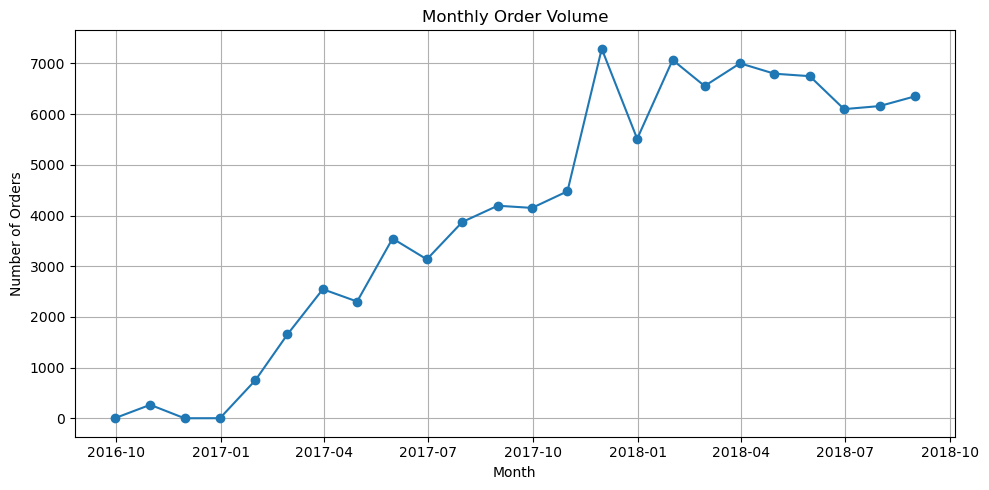

In [14]:
# Resample to month-end frequency and count number of orders
monthly_orders = df['order_id'].resample('ME').count()

# Plot monthly trend
plt.figure(figsize=(10,5))
plt.plot(monthly_orders.index, monthly_orders.values, marker='o')
plt.title('Monthly Order Volume')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.tight_layout()
plt.show()

## Product Preference Analysis

### Load order items and product info

In [17]:
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
product_category_translation = pd.read_csv('data/product_category_name_translation.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')

### Data preparation

In [19]:
# Merge order_items with products to get product category
order_products = order_items.merge(products, on='product_id', how='left')

# Merge with category translation to get English names
order_products = order_products.merge(product_category_translation, on='product_category_name', how='left')


### Top 10 most sold product categories

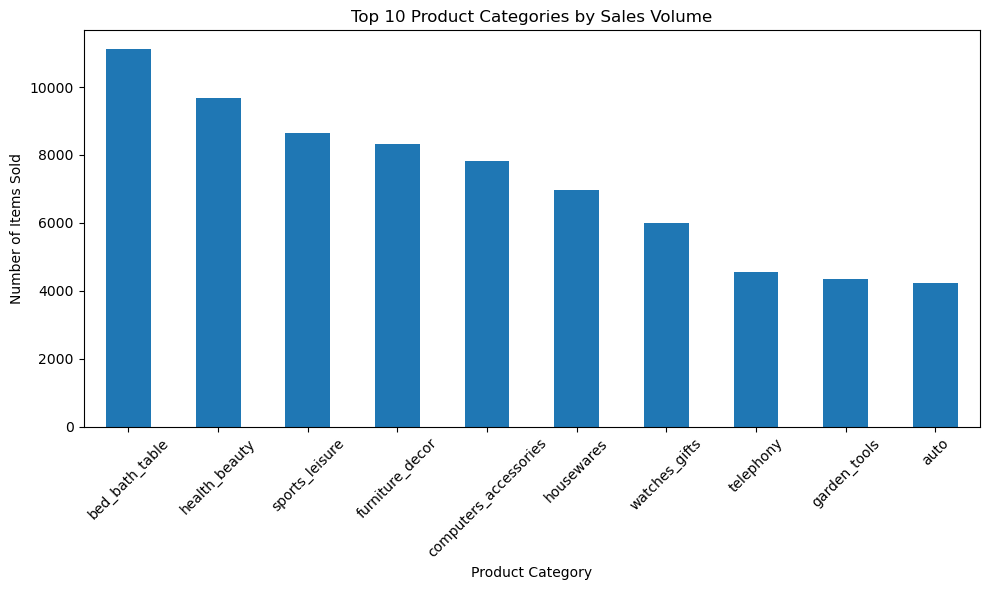

In [21]:
# Count number of items sold per category
category_sales = order_products['product_category_name_english'].value_counts().head(10)

# Plot top 10 categories by sales volume
plt.figure(figsize=(10,6))
category_sales.plot(kind='bar')
plt.title('Top 10 Product Categories by Sales Volume')
plt.xlabel('Product Category')
plt.ylabel('Number of Items Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Lowest average review scores by category

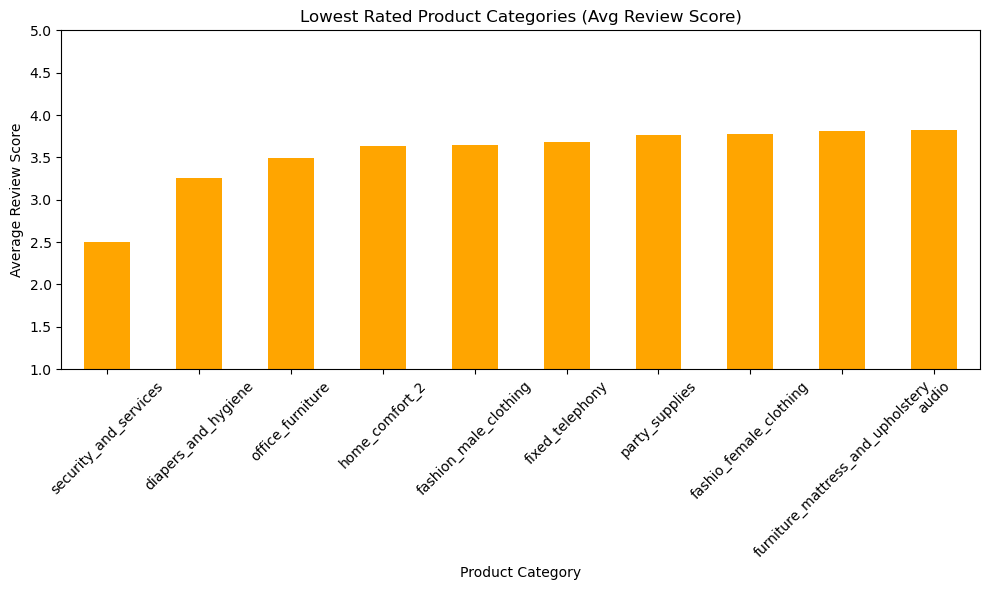

In [23]:

# Merge order_id from reviews with order_items to get product_id
order_reviews = order_items.merge(reviews[['order_id', 'review_score']], on='order_id', how='inner')

# Add product category and translation
order_reviews = order_reviews.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
order_reviews = order_reviews.merge(product_category_translation, on='product_category_name', how='left')

# Group by product category and calculate average score
category_review_scores = order_reviews.groupby('product_category_name_english')['review_score'].mean()

# Sort to find categories with lowest average rating
lowest_rated_categories = category_review_scores.sort_values().head(10)

# Plot lowest scoring categories
plt.figure(figsize=(10,6))
lowest_rated_categories.plot(kind='bar', color='orange')
plt.title('Lowest Rated Product Categories (Avg Review Score)')
plt.xlabel('Product Category')
plt.ylabel('Average Review Score')
plt.ylim(1, 5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Customer Satisfaction Analysis

### Load datasets

In [26]:
# Load review scores
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')

# Load orders and customers to get state info
orders = pd.read_csv('data/olist_orders_dataset.csv')
customers = pd.read_csv('data/olist_customers_dataset.csv')

# Load order_items and products for category info
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
category_translation = pd.read_csv('data/product_category_name_translation.csv')


### Review score distribution

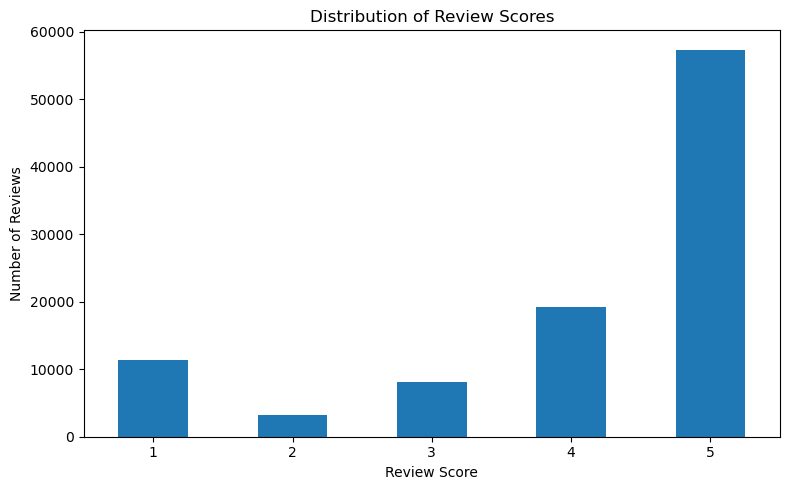

In [28]:
# Plot histogram of review scores
plt.figure(figsize=(8,5))
reviews['review_score'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Negative reviews by state

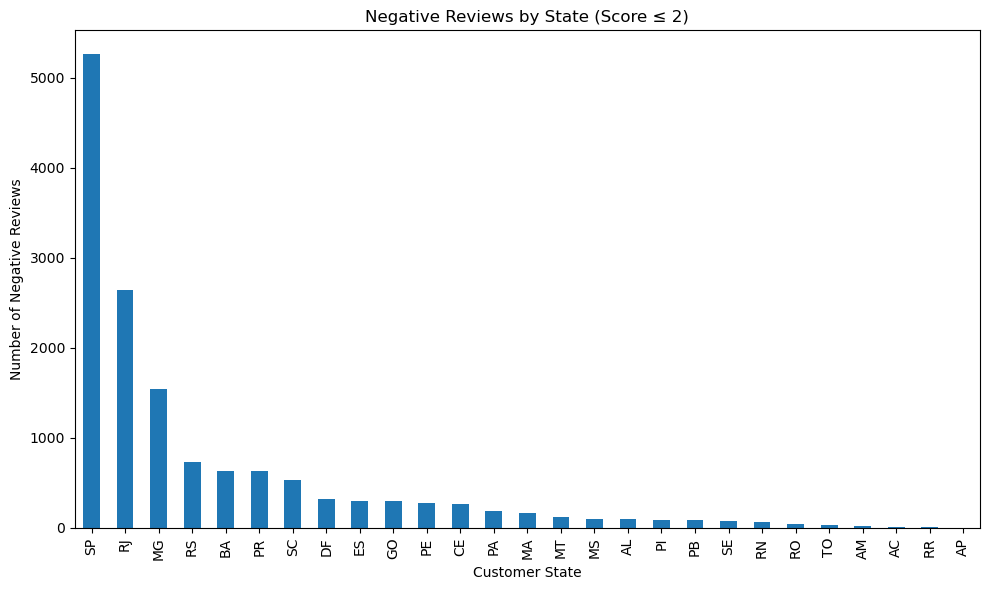

In [30]:
# Define negative review as score <= 2
negative_reviews = reviews[reviews['review_score'] <= 2]

# Merge with orders and customers to get customer_state
neg_reviews_with_state = negative_reviews.merge(orders[['order_id','customer_id']], on='order_id', how='left') \
                                         .merge(customers[['customer_id','customer_state']], on='customer_id', how='left')

# Group by state and count
neg_reviews_by_state = neg_reviews_with_state['customer_state'].value_counts().sort_values(ascending=False)

# Plot number of negative reviews by state
plt.figure(figsize=(10,6))
neg_reviews_by_state.plot(kind='bar')
plt.title('Negative Reviews by State (Score ≤ 2)')
plt.xlabel('Customer State')
plt.ylabel('Number of Negative Reviews')
plt.tight_layout()
plt.show()

### Negative reviews by product category

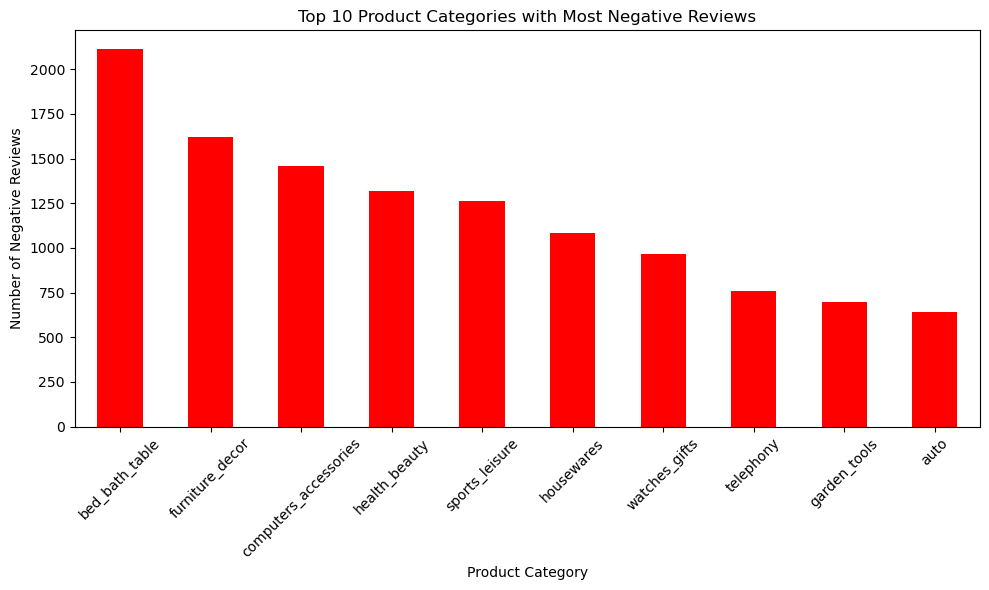

In [32]:
# Merge reviews with order_items and product info
neg_reviews_with_items = negative_reviews.merge(order_items[['order_id','product_id']], on='order_id', how='left') \
                                         .merge(products[['product_id','product_category_name']], on='product_id', how='left') \
                                         .merge(category_translation, on='product_category_name', how='left')

# Count negative reviews by product category
neg_reviews_by_category = neg_reviews_with_items['product_category_name_english'].value_counts().head(10)

# Plot top 10 product with the most negative reviews
plt.figure(figsize=(10,6))
neg_reviews_by_category.plot(kind='bar', color='red')
plt.title('Top 10 Product Categories with Most Negative Reviews')
plt.xlabel('Product Category')
plt.ylabel('Number of Negative Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()